### Compare dropout uncertainty with logvar

In [1]:
# imports
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.compat.v1 import gfile
import pdb
import pickle

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # CPU-only

sys.path.append(os.path.abspath("/home/mwu34/disentanglement_lib"))
import numpy as np
np.set_printoptions(precision=3, suppress=True)

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm

from scipy.stats import spearmanr

In [2]:
def index_to_factors(index_array, factor_bases, save=False):
    """transform dataset image indices to factors."""
    factor_bases = factor_bases.astype(int)
    factors = np.zeros((len(index_array), len(factor_bases) - 1))
    for factor_idx, factor_base in enumerate(factor_bases[1:]):
        factors[:, factor_idx], index_array = np.divmod(index_array, factor_base)
    
    if save:
        save_path = os.path.join(
            os.environ.get("DISENTANGLEMENT_LIB_DATA", "."),
            "dsprites", f"{selection_criterion}.pickle"
        )
        informative_points = {
            'informative_indices': index_array,
            'informative_factors': factors
        }
        with open(save_path, 'wb') as handle:
            pickle.dump(informative_points, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print(f'saved informative points to {save_path}')
    else:
        print('no save_path specified, not saving informative points')
    
    return factors

In [3]:
# retrieve the representation associated with the dataset
def retrieve_representation(dataset, module_path, num_random_points, random=False):
    with hub.eval_function_for_module(module_path) as f:
        def _gaussian_encoder(x):
            """Encodes images using trained model."""
            # Push images through the TFHub module.
            output = f(dict(images=x), signature="gaussian_encoder", as_dict=True)
            # Convert to numpy arrays and return.
            return {key: np.array(values) for key, values in output.items()}
        if random:
            select_indices = random_state.choice(len(dataset.images), num_random_points, replace=False)
            images = np.expand_dims(dataset.images[select_indices], 3)
            representation_dict = _gaussian_encoder(images)
            
        else:  # retrieve representation of the entire dataset
            num_points_per_block = 10000
            num_blocks = int(np.ceil(len(dataset.images) / num_points_per_block))
            representation_list = [0] * num_blocks
            for block in range(num_blocks):
                start_idx = num_points_per_block * block
                images = np.expand_dims(dataset.images[start_idx: start_idx + num_points_per_block], 3)
                representation_list[block] = _gaussian_encoder(images)
            representation_dict = dict()
            print(representation_list[0].keys())
            for key in representation_list[0].keys():
                representation_dict[key] = np.concatenate([block[key] for block in representation_list], axis=0)
            
        representation_dict['std'] = np.exp(representation_dict['logvar'] / 2)
        representation_dict['kl'] = (
            representation_dict['mean'] ** 2
            + representation_dict['std'] ** 2
            - representation_dict['logvar'] - 1
        ) / 2
        return representation_dict

In [4]:
# get the original dsprites dataset
from disentanglement_lib.data.ground_truth import named_data
dsprites = named_data.get_named_ground_truth_data('dsprites_full', -1)

In [5]:
# for a model, retrieve dropout mean and uncertainty 
model_artifact_dir = "/home/mwu34/disentanglement_lib/output_active_learning_study_v10/8/model/artifacts/"
labelled_indices = []
num_iterations = 9
num_latent = 10

dropout_mean = []
dropout_uncertainty = []

for iteration in range(10):
    file_path = os.path.join(model_artifact_dir, f"labelled_indices_iter_{iteration}.npy")
    indices = np.load(file_path)
    labelled_indices.extend(list(indices))
    if iteration > 0:
        mean_file_path = os.path.join(model_artifact_dir, f"dropout_mean_iter_{iteration}.npy")
        dropout_mean.append(np.load(mean_file_path))
        uncertainty_file_path = os.path.join(model_artifact_dir, f"dropout_uncertainty_iter_{iteration}.npy")
        dropout_uncertainty.append(np.load(uncertainty_file_path))
    
labelled_factors = index_to_factors(labelled_indices, dsprites.factor_bases, save=False)

no save_path specified, not saving informative points


In [6]:
# average uncertainty over time
average_uncertainty = np.zeros((num_iterations, num_latent))
for iteration in range(num_iterations):
    average_uncertainty[iteration, :] = np.mean(dropout_uncertainty[iteration], axis=0)
average_uncertainty

array([[0.111, 0.132, 0.139, 0.063, 0.062, 0.011, 0.011, 0.01 , 0.011,
        0.01 ],
       [0.096, 0.126, 0.115, 0.062, 0.06 , 0.003, 0.004, 0.003, 0.003,
        0.003],
       [0.091, 0.124, 0.107, 0.061, 0.06 , 0.003, 0.003, 0.003, 0.003,
        0.003],
       [0.088, 0.122, 0.105, 0.06 , 0.059, 0.003, 0.003, 0.003, 0.003,
        0.003],
       [0.089, 0.121, 0.11 , 0.06 , 0.059, 0.003, 0.003, 0.003, 0.003,
        0.003],
       [0.09 , 0.12 , 0.106, 0.06 , 0.059, 0.003, 0.003, 0.003, 0.003,
        0.003],
       [0.091, 0.12 , 0.104, 0.06 , 0.059, 0.002, 0.003, 0.003, 0.003,
        0.003],
       [0.091, 0.12 , 0.103, 0.06 , 0.059, 0.002, 0.002, 0.003, 0.003,
        0.003],
       [0.092, 0.12 , 0.1  , 0.06 , 0.059, 0.002, 0.003, 0.003, 0.003,
        0.003]])

In [7]:
# absolute mean value over time
abs_mean = np.zeros((num_iterations, num_latent))
for iteration in range(num_iterations):
    abs_mean[iteration, :] = np.mean(np.abs(dropout_mean[iteration]), axis=0)
abs_mean

array([[0.108, 0.818, 0.14 , 0.875, 0.868, 0.008, 0.009, 0.007, 0.008,
        0.01 ],
       [0.093, 0.802, 0.102, 0.856, 0.846, 0.005, 0.006, 0.005, 0.005,
        0.005],
       [0.086, 0.796, 0.09 , 0.846, 0.837, 0.004, 0.006, 0.004, 0.004,
        0.004],
       [0.081, 0.793, 0.084, 0.841, 0.834, 0.004, 0.005, 0.004, 0.004,
        0.004],
       [0.082, 0.791, 0.09 , 0.837, 0.83 , 0.004, 0.005, 0.004, 0.004,
        0.005],
       [0.083, 0.787, 0.086, 0.833, 0.827, 0.005, 0.004, 0.004, 0.004,
        0.005],
       [0.087, 0.788, 0.085, 0.832, 0.827, 0.004, 0.005, 0.005, 0.004,
        0.005],
       [0.087, 0.789, 0.085, 0.832, 0.826, 0.004, 0.004, 0.005, 0.004,
        0.005],
       [0.088, 0.79 , 0.082, 0.832, 0.826, 0.004, 0.004, 0.004, 0.004,
        0.004]])

In [8]:
# retrieve the mean and logvar for this model
module_path = "/home/mwu34/disentanglement_lib/output_active_learning_study_v10/8/model/tfhub/"
representation_dict = retrieve_representation(dsprites, module_path, -1, False)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


dict_keys(['mean', 'logvar'])


Text(0.5, 1.0, 'correlation between mean and dropout_mean')

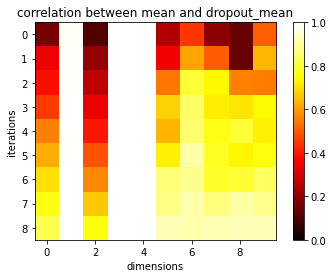

In [9]:
# compare correlation between mean and dropout_mean
mean_corr = np.zeros((num_iterations, num_latent))
for iteration in range(num_iterations):
    for latent in range(num_latent):
        results = spearmanr(representation_dict['mean'][:, latent], dropout_mean[iteration][:, latent])
        mean_corr[iteration, latent] = abs(results.correlation)
        
plt.imshow(mean_corr, cmap='hot')
plt.clim([0, 1])
plt.colorbar()
plt.xlabel('dimensions')
plt.ylabel('iterations')
plt.title('correlation between mean and dropout_mean')

In [10]:
mean_corr

array([[0.161, 0.992, 0.109, 0.999, 0.999, 0.253, 0.447, 0.198, 0.144,
        0.508],
       [0.34 , 0.993, 0.211, 1.   , 1.   , 0.349, 0.611, 0.503, 0.144,
        0.639],
       [0.385, 0.994, 0.267, 1.   , 1.   , 0.541, 0.8  , 0.736, 0.556,
        0.55 ],
       [0.452, 0.995, 0.341, 1.   , 1.   , 0.678, 0.844, 0.72 , 0.708,
        0.739],
       [0.555, 0.995, 0.397, 1.   , 1.   , 0.633, 0.855, 0.764, 0.799,
        0.723],
       [0.623, 0.996, 0.486, 1.   , 1.   , 0.725, 0.913, 0.78 , 0.733,
        0.756],
       [0.701, 0.996, 0.568, 1.   , 1.   , 0.863, 0.887, 0.787, 0.798,
        0.842],
       [0.76 , 0.997, 0.661, 1.   , 1.   , 0.877, 0.916, 0.868, 0.909,
        0.884],
       [0.822, 0.997, 0.752, 1.   , 1.   , 0.93 , 0.915, 0.925, 0.927,
        0.926]])

Text(0.5, 1.0, 'correlation between logvar and dropout_uncertainty')

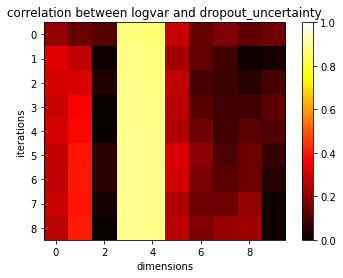

In [11]:
# compare correlation between logvar and dropout_uncertainty
uncertainty_corr = np.zeros((num_iterations, num_latent))
for iteration in range(num_iterations):
    for latent in range(num_latent):
        results = spearmanr(representation_dict['logvar'][:, latent], dropout_uncertainty[iteration][:, latent])
        uncertainty_corr[iteration, latent] = abs(results.correlation)
        
plt.imshow(uncertainty_corr, cmap='hot')
plt.clim([0, 1])
plt.colorbar()
plt.xlabel('dimensions')
plt.ylabel('iterations')
plt.title('correlation between logvar and dropout_uncertainty')

In [12]:
uncertainty_corr

array([[0.208, 0.14 , 0.11 , 0.869, 0.862, 0.28 , 0.133, 0.175, 0.126,
        0.152],
       [0.321, 0.266, 0.008, 0.88 , 0.873, 0.228, 0.134, 0.079, 0.006,
        0.016],
       [0.308, 0.309, 0.036, 0.884, 0.878, 0.273, 0.087, 0.078, 0.047,
        0.093],
       [0.287, 0.358, 0.001, 0.886, 0.882, 0.26 , 0.116, 0.083, 0.085,
        0.132],
       [0.299, 0.375, 0.004, 0.888, 0.884, 0.25 , 0.15 , 0.082, 0.122,
        0.109],
       [0.277, 0.395, 0.049, 0.889, 0.885, 0.307, 0.194, 0.099, 0.145,
        0.07 ],
       [0.271, 0.401, 0.049, 0.89 , 0.886, 0.295, 0.167, 0.121, 0.148,
        0.043],
       [0.285, 0.394, 0.023, 0.89 , 0.886, 0.243, 0.146, 0.152, 0.204,
        0.014],
       [0.261, 0.404, 0.001, 0.89 , 0.887, 0.261, 0.173, 0.217, 0.22 ,
        0.013]])

In [13]:
all_factors = index_to_factors(np.arange(len(dsprites.images)), dsprites.factor_bases, save=False)

no save_path specified, not saving informative points


Text(0.5, 1.0, 'correlation between ground_truth and dropout_mean')

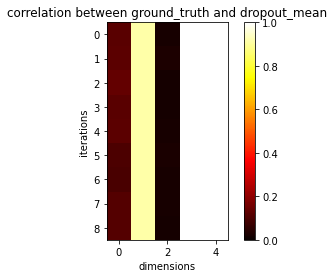

In [14]:
# compare dropout mean to ground truth factor values
num_gt_factors = 5
ground_truth_mean_corr = np.zeros((num_iterations, num_gt_factors))
for iteration in range(num_iterations):
    for latent in range(num_gt_factors):
        results = spearmanr(dropout_mean[iteration][:, latent], all_factors[:, latent])
        ground_truth_mean_corr[iteration, latent] = abs(results.correlation)
        
plt.imshow(ground_truth_mean_corr, cmap='hot')
plt.clim([0, 1])
plt.colorbar()
plt.xlabel('dimensions')
plt.ylabel('iterations')
plt.title('correlation between ground_truth and dropout_mean')

In [15]:
ground_truth_mean_corr

array([[0.119, 0.912, 0.02 , 0.997, 0.997],
       [0.122, 0.913, 0.028, 0.997, 0.997],
       [0.134, 0.913, 0.018, 0.997, 0.997],
       [0.117, 0.913, 0.018, 0.997, 0.997],
       [0.122, 0.913, 0.02 , 0.997, 0.997],
       [0.098, 0.913, 0.024, 0.997, 0.997],
       [0.097, 0.913, 0.021, 0.997, 0.997],
       [0.111, 0.913, 0.021, 0.997, 0.997],
       [0.112, 0.912, 0.018, 0.997, 0.997]])